1、正常情况下，通过网络下载对应的数据，由于网站已无法打开，使用静态数据，对应的代码如下

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"  # 这个是保存在jupyter notebook 上了
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

2、接下来需要加载数据集，并做必要的预处理。

In [2]:
#使用pandas加载数据
import pandas as pd


def load_housing_data(housing_dir="csv_list/"):
    file_path = housing_dir + "housing.csv"
    return pd.read_csv(file_path)


#查看一下数据的结果
housing_data = load_housing_data()
housing_data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
#住房信息
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB



#2-6
共有20640个数据,但是total_bedrooms只有20433个非空值，207个数据缺失该项
因为在csv中加载了此数据，所以对应的object一定是文本属性。可以使用value_counts()查看有多少种分类


In [4]:
housing_data["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


绘制直方图，绘制每个属性的直方图

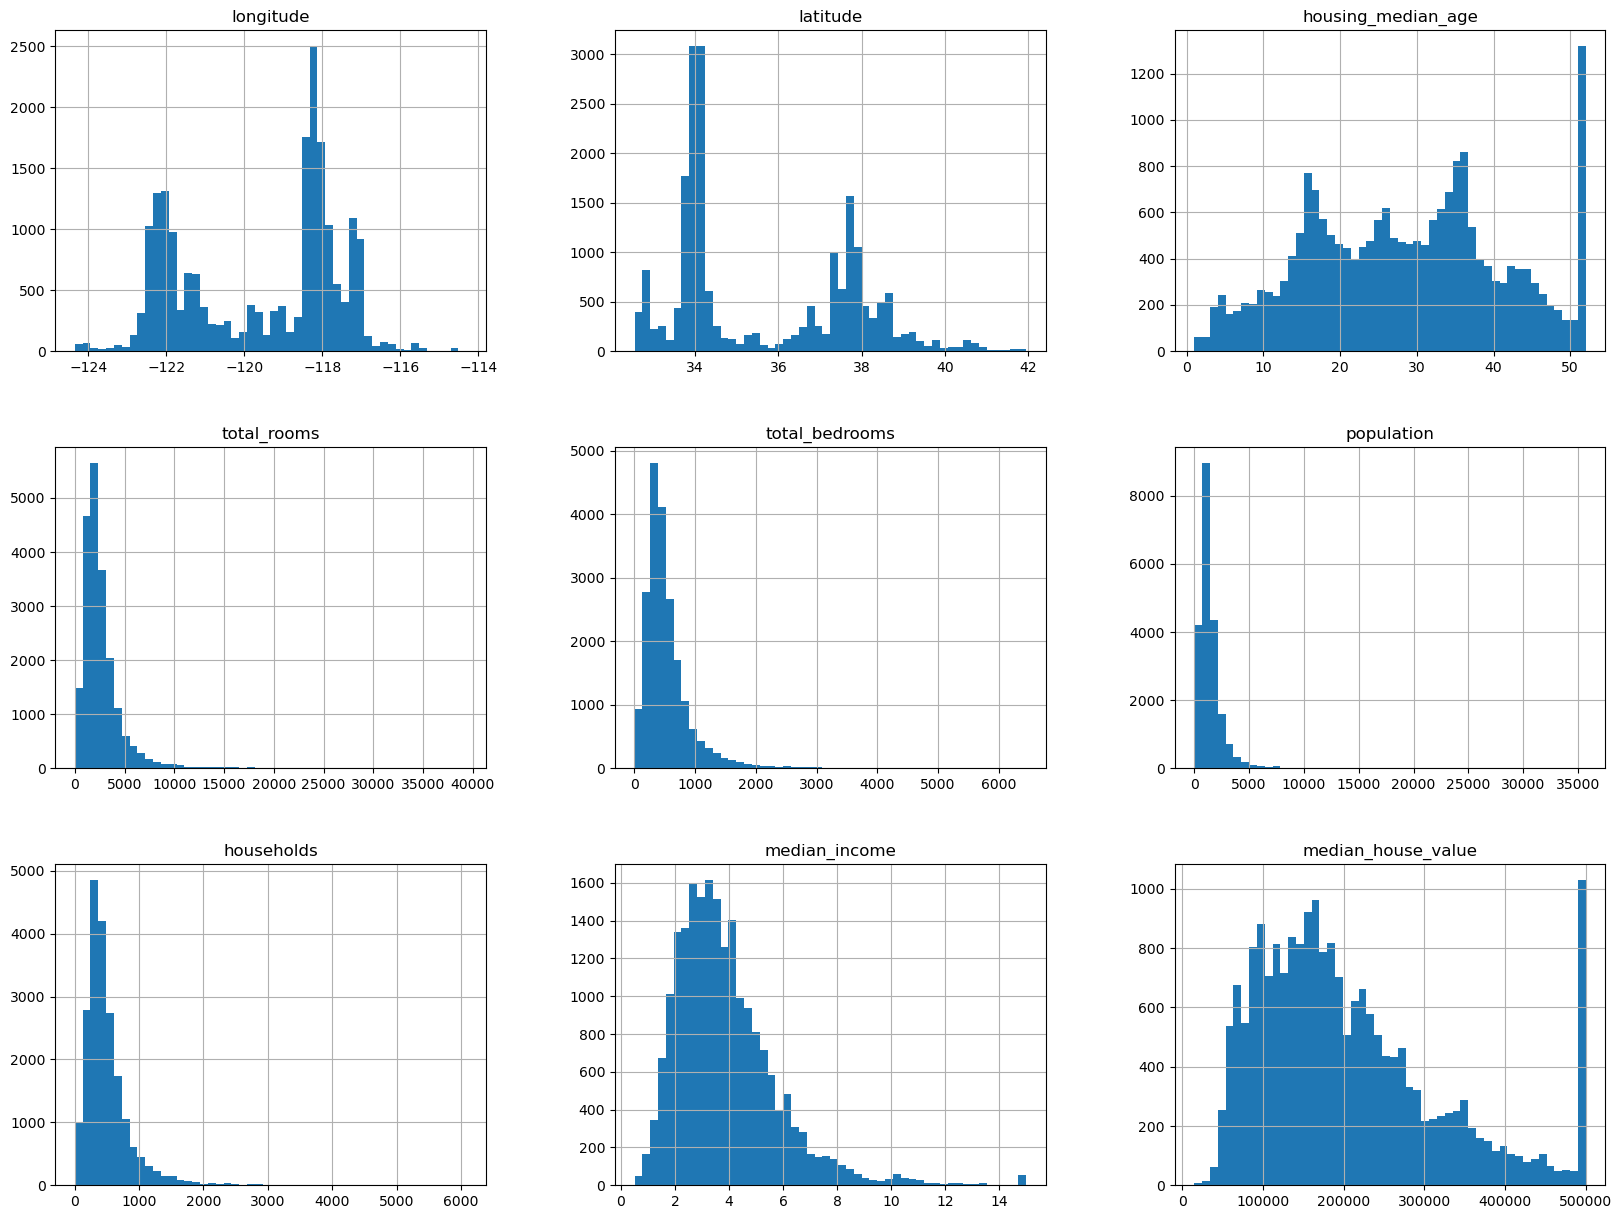

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

housing_data.hist(bins=50, figsize=(20, 15))  #直方图
plt.show()

创建一个测试集,一般来说测试集通常是数据集的20%，随即一部分数据即可


In [7]:
import numpy as np


def split_train_test(data):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * 0.2)
    train_size = len(data) - test_size
    # 从开始到train_size 
    return shuffled_indices[:train_size], data[shuffled_indices[:train_size]]

此时，将测试数据和训练数据进行了分割，但是此时并不是很完美，如果多次处理之后将会获得整个完整的数据集
解决方案一、在第一次运行程序之后即保存测试集，随后的运行只是加载它
解决方案二、在调用np.random.permutation()之前设置一个随机数生成器的种子42，始终让其生成相同的序列

但是这两种在下一次获取更新时都会中断，为了即使在更新数据集之后也有一个稳定的训练测试分割，常见的解决方案是每个实例都是用一个标识符来决定是否进入测试集
（假设每个实例都有一个唯一且不变的标识符）

例如，可以计算每个实例标识符的哈希值，如果这个哈希值小于或者等于最大哈希值的20%，则将该实例放入测试集。

In [8]:
# 实现方式如下
from zlib import crc32


def test_set_check(identifier):
    return crc32(np.int64(identifier)) & 0xffffffff < 0x80000000 < 0.2 * 2 ** 32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_))
    return data.loc[~in_test_set], data.loc[in_test_set]


#最简单的方法就是使用某个唯一的键作为作为id
housing_data_with_id = housing_data.reset_index()
train_set, test_set = split_train_test_by_id(housing_data_with_id, 0.2, "id")

KeyError: 'id'

In [8]:

#如果使用索引作为唯一标识符，需要确保在数据集的末尾添加新数据，并且不会删除任何行。
#如果不可以，那么可以使用某个最稳定的特征作为唯一标识符。例如经纬度
housing_with_id = housing_data["longitude"] * 1000 + housing_data["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

NameError: name 'split_train_test_by_id' is not defined

In [10]:
#Scikit_learn 提供了一些函数，可以通过多种方式将数据分为多个子表，函数名也train_test_split()
import sklearn.model_selection as sk_ms

train_set, test_set = sk_ms.train_test_split(housing_data, test_size=0.2)


<Axes: >

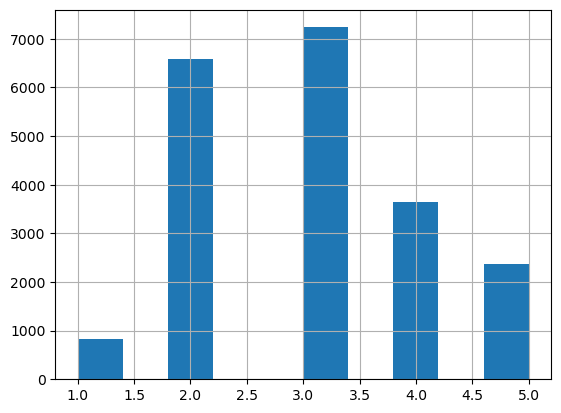

In [11]:
#尝试查看income的中位数直方图，大部分的收入中位数聚集在15000-60000
# 在展示直方图的过程中，每一层都需要有足够多的实例，这是至关重要的
housing_data["income_cat"] = pd.cut(housing_data["median_income"], bins=[0., 1.5, 3., 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])
housing_data["income_cat"].hist()

现在可以根据收入类别进行分层抽样了，使用Scikit_learn的StratifiedShuffle-split类

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

#收入类别的直方图
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

2.4 从数据探索和可视化中获得洞见


2.4.1 将地理数据可视化
以经纬度为xy，创建坐标系

<Axes: xlabel='longitude', ylabel='latitude'>

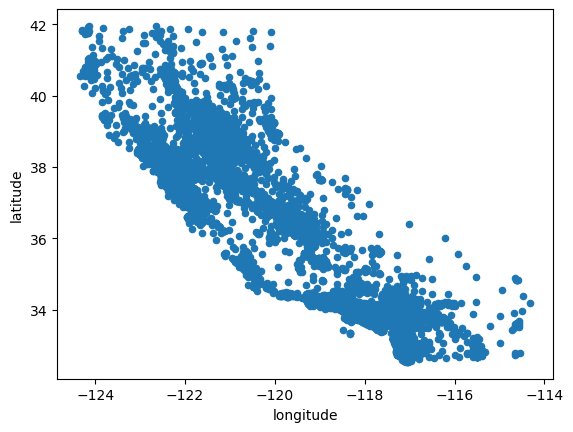

In [13]:
housing_data.plot(kind="scatter", x= "longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

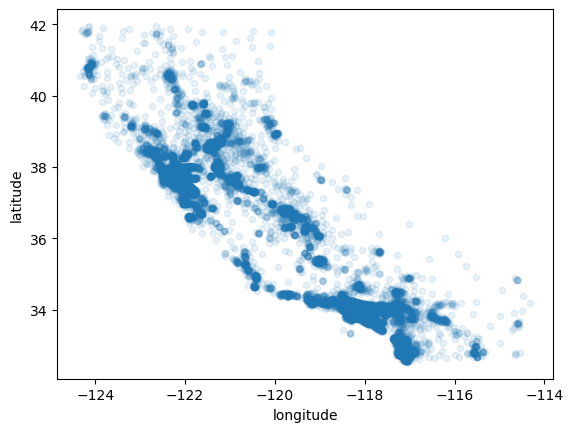

In [14]:
#设置密度高亮
housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

现在来看看房价，每个圆圈的半径大小代表了每个区域打的人口数量（选项s），意思代表价格（选项c），我们使用一个名叫jet的预定义颜色表（选项cmap）
来进行过可视化，颜色范围从蓝到红


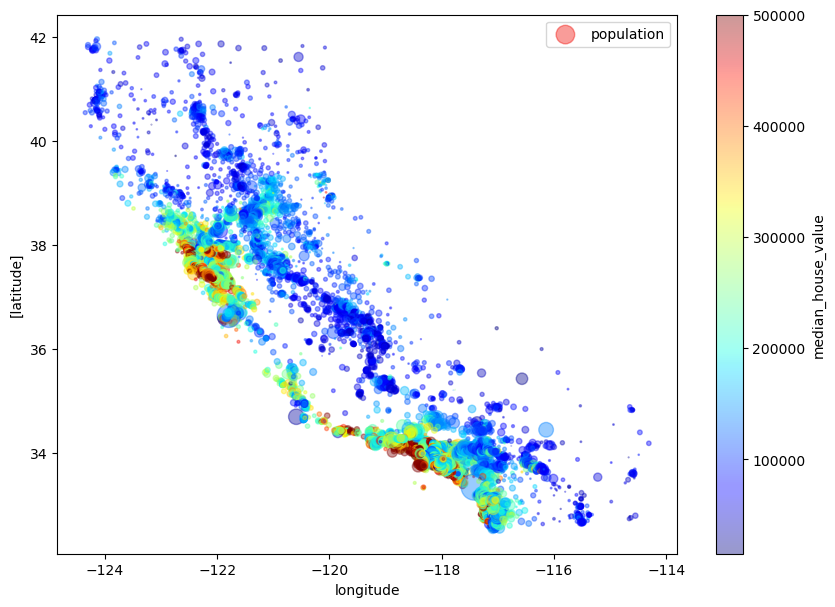

In [26]:
housing_data.plot(kind="scatter", x="longitude", y=["latitude"], alpha=0.4, s=housing_data["population"]/ 100, label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"))
plt.legend()

2.4.2 寻找相关性，对于少量的数据集可以通过corr()方法轻松计算出没对属性之间的标准系数
‌标准相关系数公式是相关系数r的计算公式，用于度量两个变量之间的线性相关程度。‌ 相关系数r的取值范围在-1到1之间，表示两个变量之间的相关方向和强度。r值为正表示正相关，r值为负表示负相关，r的绝对值等于1表示两个变量完全相关‌12。

相关系数的计算公式有多种形式，以下是几种常见的形式：

‌总体相关系数‌：ρXY=Cov(X,Y)/√[D(X)]√[D(Y)]，其中Cov(X,Y)是X和Y的协方差，D(X)和D(Y)分别是X和Y的方差‌1。


In [15]:
# corr_matrix = housing_data.corr()
# corr_matrix["median_house_value"].sort_values(ascending=False)
#出现一些数据上的小问题，需要清洗

相关系数仅能测量线性相关性（如果x上升，则y下降的这种），所有它有可能彻底遗漏非线性相关性（例如，如果x接近0，则y上升，即y = 1 / x）
很显然此时的x和y并不是没有相关性，并不是完全独立的
还有一种方法可以检测属性之间的相关性，就是使用pandas的scatter_mattrix函数，可以绘制出每个数值属性对于其他数值属性的相关性。
当前有11个元素，那么将会拥有121个图像，可以选择重点关注


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_bedrooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_bedrooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_bedrooms'>,
        <Axes: xlabel='median_income', ylabel='total_bedrooms'>,
        <Axes: xlabel='total_bedrooms', ylabel='total_bedrooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_bedrooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_

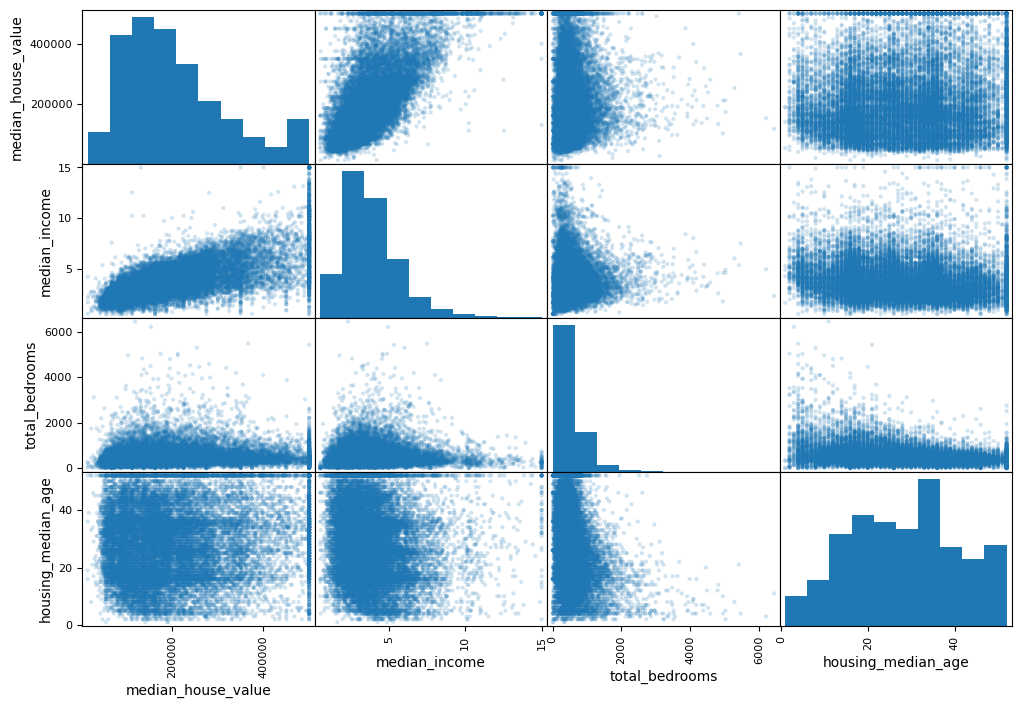

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_bedrooms", "housing_median_age"]
scatter_matrix(housing_data[attributes], alpha=0.2, figsize=(12, 8))

预测房价最精准的还是收入中位数，所以我们放大看看其相关性的散点数

<Axes: xlabel='median_income', ylabel='median_house_value'>

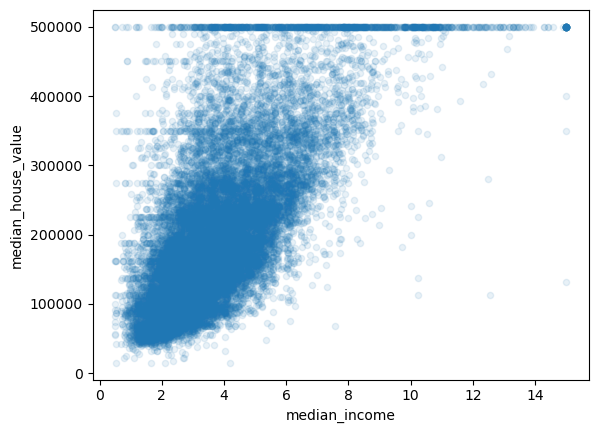

In [17]:
housing_data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

2.5 机器学习的数据准备

2.5.1 数据清洗
大部分的机器学习算法无法在缺失的特征上工作，我们要创建一些函数来辅佐它。
前面我们已经注意到total_bedrooms属性上有部分缺失，所以我们要解决它，有如下三种方式：
1、放弃这些对应的区域
2、放弃整个个属性
3、将缺失的值设置为某个值（0， 平均数或者中位数等）
通过DataFrame的dropna()、drop()、fillna()方法，可以轻松完成这些操作


In [18]:
# housing_data.dropna(subset=["total_bedrooms"]) #option1
# housing_data.dropna(subset=["total_bedrooms"],axis=0) #option2

median = housing_data["total_bedrooms"].median() #option3
housing_data["total_bedrooms"].fillna(median, inplace=True)

#如果选择方法3，需要计算训练集的中位数，然后填充训练集中的缺失值

In [19]:
#scikit_learn提供了一个非常容易上手的类处理缺失值，SimpleImputer，首先创建一个SimpleImputer实例，指定要用属性的中位数一环该属性的缺失值
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')


In [ ]:
#由于中位数只能在数值属性上计算，所以我们需要创建一个没有文本属性ocean_proximity的数据副本
housing_num = housing_data.drop("ocean_proximity", axis=1)
#使用fit()方法将imputer实例适配到训练数据
imputer.fit(housing_num)

这里imputer仅仅只是计算了每个属性的中位数值，并将结果存储在其实例变量statistics_中。虽然只有total_bedrooms这个属性存在缺失值，但是我们确认系统启动之后新数据中是否一定它不存在任何缺失值，所以稳妥起见，imputer应该用于所有的数值属性

In [ ]:
x = imputer.transform(housing_num)
#结果是一个包含转换后特征的NumPy数组。如果想将它放回pandas DataFrame，也很简单
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_data.index)